# AOC2022

## Day 17 / Part 1 / Pyroclastic Flow

Problem Description: https://adventofcode.com/2022/day/17

Input: [Example](aoc2022_day17_example.txt)

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
"""Solution for AOC2022, day 17, part 1."""
from collections import OrderedDict
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np

LOGGER = logging.getLogger(__name__)
plt.rcParams["figure.figsize"] = [1, 200]

# show/hide overview
SHOW_OVERVIEW = True
# show/hide debug logs
SHOW_DEBUG_LOG = False
# set input file
INPUT_FILE = "aoc2022_day17_example.txt"

In [3]:
ROCKS_TO_SIMULATE = 2022
FLOOR_WIDTH = 7

ROCK_TYPES = OrderedDict({
    "I1": [[1, 1, 1, 1]],
    "X1": [[0, 1, 0],
           [1, 1, 1],
           [0, 1, 0]],
    "V1": [[0, 0, 1],
           [0, 0, 1],
           [1, 1, 1]],
    "I2": [[1],
           [1],
           [1],
           [1]],
    "O1": [[1, 1],
           [1, 1]]
})

In [4]:
class Rock:
    """Class representing a rock."""
    shape = None
    position = None
    chamber = None

    def __init__(self, shape, position, chamber):
        self.shape = shape
        self.position = position
        self.chamber = chamber

    def push(self, jet):
        """
        Push the rock to the left or right depending on the jet
        and blocking objects.
        """
        if jet == ">":
            if (
                (
                    self.position[1] + 1 >
                    self.chamber.floor_width-self.shape.shape[1]
                ) or self.check_collition(y_shift=0, x_shift=1)
            ):
                return
            self.position = (self.position[0], self.position[1] + 1)
        else:
            if (
                self.position[1] - 1 < 0 or
                self.check_collition(y_shift=0, x_shift=-1)
            ):
                return
            self.position = (self.position[0], self.position[1] - 1)

    def try_fall(self, ignore_collition=False):
        """
        Let the rock fall for one unit if space below is empty.
        Otherwise, raises a RuntimeError if ignore_collition=False.
        """
        if not ignore_collition:
            if self.check_collition(y_shift=-1, x_shift=0):
                raise RuntimeError("Found collition!")
        self.position = (self.position[0]-1, self.position[1])

    def check_collition(self, y_shift, x_shift):
        """
        Check wherever the rock collides with another object
        if it is shifted in y/x by y_shift and/or x_shift units.
        """
        if self.position[0] - (self.shape.shape[0]-1) + y_shift < 0:
            return True
        for y_pos in range(self.shape.shape[0]):
            for x_pos in range(self.shape.shape[1]):
                if self.shape[y_pos, x_pos] == 0:
                    continue
                if (
                    self.position[0] - y_pos + y_shift,
                    self.position[1] + x_pos + x_shift
                ) in self.chamber.occupied_space:
                    return True
        return False


class Chamber:
    """Class representing a chamber with rocks at occupied_space."""
    floor_width = None
    jet_pattern = None

    next_rock_type_id = 0
    next_jet_id = 0

    stack_height = 0
    occupied_space = set()

    def __init__(self, floor_width, jet_pattern):
        self.floor_width = floor_width
        self.jet_pattern = jet_pattern
        self.next_rock_type_id = 0
        self.next_jet_id = 0
        self.stack_height = 0
        self.occupied_space = set()

    def get_next_rock_type(self):
        """Get the next falling rock type."""
        curr_rock_type_id = self.next_rock_type_id
        self.next_rock_type_id = (self.next_rock_type_id + 1) % len(ROCK_TYPES)
        return list(ROCK_TYPES)[curr_rock_type_id]

    def get_next_jet(self):
        """Get the next jet."""
        curr_jet_id = self.next_jet_id
        self.next_jet_id = (self.next_jet_id + 1) % len(self.jet_pattern)
        return self.jet_pattern[curr_jet_id]

    def set_rock(self, rock):
        """Set a rock in the chamber."""
        for y_pos in range(rock.shape.shape[0]):
            for x_pos in range(rock.shape.shape[1]):
                if rock.shape[y_pos, x_pos] == 0:
                    continue
                self.occupied_space.add(
                    (rock.position[0] - y_pos, rock.position[1] + x_pos)
                )
        self.stack_height = max(self.stack_height, rock.position[0]+1)

    def simulate(self, stones):
        """Simulate falling stones in the chamber."""
        LOGGER.debug("simulate falling rocks...")
        for _ in range(stones):
            rock_type = self.get_next_rock_type()
            rock_shape = np.array(ROCK_TYPES[rock_type])
            start_pos = (self.stack_height + 3 + (rock_shape.shape[0]-1), 2)
            rock = Rock(rock_shape, start_pos, self)

            # push action
            # we do not need to check for a collition during the first
            # three fallen stones
            for _ in range(3):
                jet = self.get_next_jet()
                rock.push(jet)
                rock.try_fall(ignore_collition=True)

            while True:
                jet = self.get_next_jet()
                rock.push(jet)
                try:
                    rock.try_fall(ignore_collition=False)
                except RuntimeError:
                    LOGGER.debug(
                        "  rock (of type %s) starts at %s and ends at %s",
                        rock_type, start_pos, rock.position
                    )
                    self.set_rock(rock)
                    break
        LOGGER.debug("")

    def to_array(self, max_y_pos=None):
        """Return the chamber with all containing rocks as array."""
        max_x_pos = FLOOR_WIDTH - 1
        if max_y_pos is None:
            max_y_pos = 0
            for y_pos, x_pos in self.occupied_space:
                max_y_pos = max(max_y_pos, y_pos)

        space = np.zeros((max_y_pos+1, max_x_pos+1))
        for y_pos, x_pos in self.occupied_space:
            if y_pos <= max_y_pos:
                space[max_y_pos-y_pos, x_pos] = 1

        return space

In [5]:
def main():
    """Main function to solve puzzle."""
    with open(INPUT_FILE, encoding="utf-8") as file_obj:
        jet_pattern = file_obj.readline()

    chamber = Chamber(FLOOR_WIDTH, jet_pattern)
    chamber.simulate(ROCKS_TO_SIMULATE)

    if SHOW_OVERVIEW:
        print("overview:")
        plt.imshow(chamber.to_array())
        plt.ylabel(" ")
        plt.show()

    print(f"solution: {chamber.stack_height}")

overview:


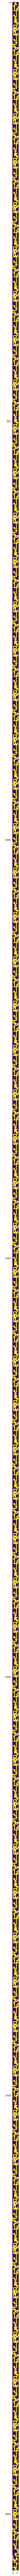

solution: 3068


In [6]:
if __name__ == "__main__":
    LOGGER.setLevel(logging.DEBUG if SHOW_DEBUG_LOG else logging.INFO)
    log_formatter = logging.Formatter("%(message)s")
    log_handler = logging.StreamHandler(sys.stdout)
    log_handler.setFormatter(log_formatter)
    LOGGER.addHandler(log_handler)
    main()